# Introduction

This notebook is based on the notebooks made by [Oscar Villarreal Escamilla](https://www.kaggle.com/oxzplvifi), [Arc](https://www.kaggle.com/sgreiner) and [CroDoc](https://www.kaggle.com/crodoc).

Please upvote the original notebooks:

https://www.kaggle.com/code/oxzplvifi/pixel-travel-map

https://www.kaggle.com/code/sgreiner/pixel-travel-map-removing-duplicates

https://www.kaggle.com/code/crodoc/82409-improved-baseline-santa-2022

**Improvements comparing to previous notebooks**:
- Rotate at most 3 links instead of 2
- Moved (below == 0) condition out of the loops to speed up code a bit

However, using more than 3 links doesn't seem to make any significant improvements.

This notebook uses a binary matrix in order to keep a record of each pixel that has been visited, called a "pixel travel map". During its travels, the arm is asked to follow three simple rules:
* If it is possible to go one step down, then ignore all other directions and go one step down. This is with the intention of avoiding "travel holes" in the map which could become costly to return to once we are far away.
* If it is not possible to go one step down, then consider all possible single-link and double-link motions and choose the one that (1) takes us to an unvisited pixel, and (2) has the least cost.
* If we become surrounded by visited pixels, then we travel to the nearest unvisited pixel no matter how many visited pixels we need to re-visit.

We start by loading the functions kindly shared by the organizers:
* https://www.kaggle.com/code/ryanholbrook/getting-started-with-santa-2022

The path compression basically tries to do move as many links the same time as possible to save on reconfiguration cost.

In [1]:
from functools import reduce
from tqdm import tqdm
import numba as nb

def get_position(config):
    return reduce(lambda p, q: (p[0] + q[0], p[1] + q[1]), config, (0, 0))

def compress_path(path):
    
    if len(path) > 2:
        new_path = []
        max_conf_dist = 1
        r = [[] for _ in range(len(path[0]))]
        for p in path:
            for i, c in enumerate(p):
                if len(r[i]) == 0 or r[i][-1] != c:
                    if c not in r[i]:
                        r[i].append(c)
                    else:
                        r[i] = r[i][:r[i].index(c) + 1]
                    assert r[i][-1] == c
        
        max_conf_dist = max([len(r_) for r_ in r])
        for i in range(max_conf_dist):
            new_conf = []
            for _, r_ in enumerate(r):
                
                if i < len(r_):
                    c_ = r_[i]
                else:
                    c_ = r_[-1]
                new_conf.append(c_)
            new_path.append(new_conf)
        return new_path
    return path

def rotate_link(vector, direction):
    x, y = vector
    if direction == 1:  # counter-clockwise
        if y >= x and y > -x:
            x -= 1
        elif y > x and y <= -x:
            y -= 1
        elif y <= x and y < -x:
            x += 1
        else:
            y += 1
    elif direction == -1:  # clockwise
        if y > x and y >= -x:
            x += 1
        elif y >= x and y < -x:
            y += 1
        elif y < x and y <= -x:
            x -= 1
        else:
            y -= 1
    return (x, y)

def rotate(config, i, direction):
    config = config.copy()
    config[i] = rotate_link(config[i], direction)
    return config

def get_direction(u, v):
    """Returns the sign of the angle from u to v."""
    direction = np.sign(np.cross(u, v))
    if direction == 0 and np.dot(u, v) < 0:
        direction = 1
    return direction

@nb.jit(target_backend='cuda')
def reconfiguration_cost(from_config, to_config):
    diffs = np.abs(np.asarray(from_config) - np.asarray(to_config)).sum(axis=1)
    assert diffs.max() <= 1
    return np.sqrt(diffs.sum())

@nb.jit(target_backend='cuda')
def color_cost(from_position, to_position, image_, color_scale=3.0):
    return np.abs(image_[to_position] - image_[from_position]).sum() * color_scale


# Total cost of one step: the reconfiguration cost plus the color cost
@nb.jit(target_backend='cuda')
def step_cost(from_config, to_config, image_):
    pos_from = get_position(from_config)
    pos_to = get_position(to_config)
    from_position = cartesian_to_array(pos_from[0], pos_from[1], image_.shape)
    to_position = cartesian_to_array(pos_to[0], pos_to[1], image_.shape)
    return (reconfiguration_cost(from_config, to_config) +
            color_cost(from_position, to_position, image_))


def get_path_to_point(config, point):
    """Find a path of configurations to `point` starting at `config`."""
    path = [config]
    # Rotate each link, starting with the largest, until the point can
    # be reached by the remaining links. The last link must reach the
    # point itself.
    for i in range(len(config)):
        link = config[i]
        base = get_position(config[:i])
        relbase = (point[0] - base[0], point[1] - base[1])
        position = get_position(config[:i+1])
        relpos = (point[0] - position[0], point[1] - position[1])
        radius = reduce(lambda r, link: r + max(abs(link[0]), abs(link[1])), config[i+1:], 0)
        # Special case when next-to-last link lands on point.
        if radius == 1 and relpos == (0, 0):
            config = rotate(config, i, 1)
            if get_position(config) == point:  # Thanks @pgeiger
                path.append(config)
                break
            else:
                continue
        while np.max(np.abs(relpos)) > radius:
            direction = get_direction(link, relbase)
            config = rotate(config, i, direction)
            path.append(config)
            link = config[i]
            base = get_position(config[:i])
            relbase = (point[0] - base[0], point[1] - base[1])
            position = get_position(config[:i+1])
            relpos = (point[0] - position[0], point[1] - position[1])
            radius = reduce(lambda r, link: r + max(abs(link[0]), abs(link[1])), config[i+1:], 0)
    assert get_position(path[-1]) == point
    
    path = compress_path(path)
    
    return path

def get_path_to_configuration(from_config, to_config):
    path = [from_config]
    config = from_config.copy()
    while config != to_config:
        for i in range(len(config)):
            config = rotate(config, i, get_direction(config[i], to_config[i]))
        path.append(config)
    assert path[-1] == to_config
    
    path = compress_path(path)
    
    return path

def config_to_string(config):
    return ';'.join([' '.join(map(str, vector)) for vector in config])

c:\Users\15526\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Next, in order to simplify conversion of coordinates during our travels from Cartesian to Array and viceversa, we flip the X axis and transpose the X-Y axes of the image so that the conversion becomes:
* From Cartesian coordinates to Array indices we sum the image radius to the X and Y coordinates.
* From Array indices to Cartesian coordinates we subtract the image radius from the X and Y indices.

In [2]:
import numpy as np, pandas as pd

# Read image as a numpy array:
df_image = pd.read_csv('image.csv')
side = df_image.x.nunique()
radius = df_image.x.max()
image = df_image[['r','g','b']].values.reshape(side,side,-1)

# Flip X axis and transpose X-Y axes to simplify cartesian to array mapping:
image = image[::-1,:,:]
image = np.transpose(image, (1, 0, 2))

# Traveling

In more detail, the algorithm consists of the following simple steps:
1. Create a binary array containing a value of 1 for every pixel which has not been visited and a value of 0 for every pixel which has been visited.
2. Consider all single-link and double-link steps which end up in a place that we have not visited before, keeping a record of the step with the lowest cost. If it is possible to go one step down, then we go down and ignore all other options. If it is not possible to go down, then we go in the direction of least cost. We always push the arm to go down in order to avoid the creation of unvisited holes in the path, which will be costly to re-visit once we have moved far away.
3. If the arm becomes completely surrounded by visited sites ("stuck condition"), first we search for the nearest unvisited site, then we use the "get_path_to_point" function shared by the organizers in order to reach it in the shortest path.
4. Once every single pixel in the travel map has been completely visited, we ask our arm to return to the original configuration through the "get_path_to_configuration" function shared by the organizers.

# Points to Path

In [3]:
import numba as nb

@nb.jit(target_backend='cuda')
def get_path_to_configuration_loss(from_config, to_config):
    loss = 0
    path = [from_config]
    config = from_config.copy()
    while config != to_config:
        for i in range(len(config)):
            config = rotate(config, i, get_direction(config[i], to_config[i]))
        path.append(config)
        loss +=1
    assert path[-1] == to_config
    
    path = compress_path(path)
    
    return loss

In [4]:
def cartesian_to_array(x, y, shape_):
    m, n = shape_[:2]
    i_ = (n - 1) // 2 - y
    j = (n - 1) // 2 + x
    if i_ < 0 or i_ >= m or j < 0 or j >= n:
        raise ValueError("Coordinates not within given dimensions.")
    return i_, j

# @nb.jit(target_backend='cuda')
def reconfiguration_cost(from_config, to_config):
    diffs = np.abs(np.asarray(from_config) - np.asarray(to_config)).sum(axis=1)
    assert diffs.max() <= 1
    return np.sqrt(diffs.sum())

# Cost of moving from one color to another: the sum of the absolute change in color components
# @nb.jit(target_backend='cuda')
def color_cost(from_position, to_position, image_, color_scale=3.0):
    return np.abs(image_[to_position] - image_[from_position]).sum() * color_scale


# Total cost of one step: the reconfiguration cost plus the color cost
# @nb.jit(target_backend='cuda')
def step_cost(from_config, to_config, image_):
    pos_from = get_position(from_config)
    pos_to = get_position(to_config)
    from_position = cartesian_to_array(pos_from[0], pos_from[1], image_.shape)
    to_position = cartesian_to_array(pos_to[0], pos_to[1], image_.shape)
    return (reconfiguration_cost(from_config, to_config) +
            color_cost(from_position, to_position, image_))


# Compute total cost of path over image
# @nb.jit(target_backend='cuda')
def total_cost(path, image_):
    cost = 0
    for i_ in range(1, len(path)):
        cost += step_cost(path[i_ - 1], path[i_], image_)
    return cost

# @nb.jit(target_backend='cuda')
def get_path_to_point_loss(config, point):
    """Find a path of configurations to `point` starting at `config`."""
    path = [config]
    path_cache= path
    l1 = len(path)
#     print("l1:", l1)
    
    # Rotate each link, starting with the largest, until the point can
    # be reached by the remaining links. The last link must reach the
    # point itself.
    for i in range(len(config)):
        link = config[i]
        base = get_position(config[:i])
        relbase = (point[0] - base[0], point[1] - base[1])
        position = get_position(config[:i+1])
        relpos = (point[0] - position[0], point[1] - position[1])
        radius = reduce(lambda r, link: r + max(abs(link[0]), abs(link[1])), config[i+1:], 0)
        # Special case when next-to-last link lands on point.
        if radius == 1 and relpos == (0, 0):
            config = rotate(config, i, 1)
            if get_position(config) == point:  # Thanks @pgeiger
                path.append(config)
                break
            else:
                continue
        while np.max(np.abs(relpos)) > radius:
            direction = get_direction(link, relbase)
            config = rotate(config, i, direction)
            path.append(config)
            link = config[i]
            base = get_position(config[:i])
            relbase = (point[0] - base[0], point[1] - base[1])
            position = get_position(config[:i+1])
            relpos = (point[0] - position[0], point[1] - position[1])
            radius = reduce(lambda r, link: r + max(abs(link[0]), abs(link[1])), config[i+1:], 0)
    assert get_position(path[-1]) == point
    
    path = compress_path(path)
    l2 = total_cost(path, image) #len(path)
#     print("l2:", l2)
    
    return path, l2

In [5]:
def twopart(n):
    return n&(n-1) == 0

In [15]:
# Prepare pixel travel map:
unvisited = np.ones([side,side]) # one = unvisited pixel; 0 = visited pixel
total = side*side - 1 #total number of pixels minus the origin
origin = [(64,0),(-32,0),(-16,0),(-8,0),(-4,0),(-2,0),(-1,0),(-1,0)] #origin configuration
config = origin.copy() #future configuration

result = [config]
pbar = tqdm(total=total)

# Continue until all locations have been visited:
while(total):
    
    # Optimization variables:
    cost = 1e6
    distance = 1e6
    found = False
    
    # Current configuration:
    base = get_position(config)
    base_arr = (base[0]+radius, base[1]+radius)
    unvisited[base_arr] = 0
    
    # Is the location one step below unvisited?
    if base[1]==-128: #if we reached the bottom border
        below = 0
    else:
        below = unvisited[(base_arr[0],base_arr[1]-1)]
    
    # Single-link step:
    for i in range(len(origin)): #for each arm link
        for d in [-1,1]: #for each direction
            # Rotate link and get new position and vertical displacement:
            config_cur = rotate(config, i, d)
            pos = get_position(config_cur)
            dy = pos[1] - base[1]
            
            # Convert from cartesian to array coordinates and measure cost:
            pos_arr = (pos[0]+radius, pos[1]+radius)
            cost_cur = 1 + color_cost(base_arr, pos_arr, image)
            
            # Must move down unless impossible:
            if unvisited[pos_arr] and cost_cur < cost and (dy<0 or (dy>=0 and below==0)): 
                config_next = config_cur.copy()
                cost = cost_cur
                found = True

    if below == 0:
        # Double-link step:
        for i in range(len(origin)-1):
            for d1 in [-1,1]:
                config_cur_i = rotate(config, i, d1)
                
                for j in range(i+1,len(origin)):
                    for d2 in [-1,1]:
                        
                        # Rotate two separate links, get position and vertical displacement:
                        config_cur_j = rotate(config_cur_i, j, d2)
                        pos = get_position(config_cur_j)
                        dy = pos[1] - base[1]

                        # Convert from cartesian to array coordinates and measure cost:
                        pos_arr = (pos[0]+radius, pos[1]+radius)
                        cost_cur = np.sqrt(2) + color_cost(base_arr, pos_arr, image)

                        # Must move down unless impossible:
                        if(unvisited[pos_arr] and cost_cur < cost): 
                            config_next = config_cur_j.copy()
                            cost = cost_cur
                            found = True
                            
                        for k in range(j+1,len(origin)):
                            for d3 in [-1,1]:
                                config_cur_k = rotate(config_cur_j, k, d3)
                                pos = get_position(config_cur_k)
                                dy = pos[1] - base[1]

                                # Convert from cartesian to array coordinates and measure cost:
                                pos_arr = (pos[0]+radius, pos[1]+radius)
                                cost_cur = np.sqrt(3) + color_cost(base_arr, pos_arr, image)

                                # Must move down unless impossible:
                                if(unvisited[pos_arr] and cost_cur < cost): 
                                    config_next = config_cur_k.copy()
                                    cost = cost_cur
                                    found = True
                                    
                                for m in range(k+1,len(origin)):
                                    for d4 in [-1,1]:
                                        config_cur_m = rotate(config_cur_k, m, d4)
                                        pos = get_position(config_cur_m)
                                        dy = pos[1] - base[1]
#
                                         # Convert from cartesian to array coordinates and measure cost:
                                        pos_arr = (pos[0]+radius, pos[1]+radius)
                                        cost_cur = 2 + color_cost(base_arr, pos_arr, image)

                                        #Must move down unless impossible:
                                        if(unvisited[pos_arr] and cost_cur < cost): 
                                            config_next = config_cur_m.copy()
                                            cost = cost_cur
                                            found = True

                                   #     for h in range(m+1,len(origin)):
                                      #      for d5 in [-1,1]:
                                      #          config_cur_h = rotate(config_cur_m, h, d5)
                                       #         pos = get_position(config_cur_h)
                                        #        dy = pos[1] - base[1]

                                                # Convert from cartesian to array coordinates and measure cost:
                                         #       pos_arr = (pos[0]+radius, pos[1]+radius)
                                          #      cost_cur = np.sqrt(5) + color_cost(base_arr, pos_arr, image)
#
                                           #     if(unvisited[pos_arr] and cost_cur < cost): 
                                           #         config_next = config_cur_h.copy()
                                           #         cost = cost_cur
                                           #         found = True   

                                         #       for l in range(h+1,len(origin)):
                                            #        for d6 in [-1,1]:
                                         #               config_cur_l = rotate(config_cur_h, l, d6)
                                           #             pos = get_position(config_cur_l)
                                         #               dy = pos[1] - base[1]

                                                    # Convert from cartesian to array coordinates and measure cost:
                                             #           pos_arr = (pos[0]+radius, pos[1]+radius)
                                             #           cost_cur = np.sqrt(6) + color_cost(base_arr, pos_arr, image)
#
                                                     #Must move down unless impossible:
                                                #        if(unvisited[pos_arr] and cost_cur < cost): 
                                             #               config_next = config_cur_l.copy()
                                                      #      cost = cost_cur
                                               #             found = True   

    # If an unvisited point was found, we are done for this step:
    if found:
        config = config_next.copy()
        pos = get_position(config)
        total -= 1
        pbar.update(1)
        result.append(config)
                
    # Otherwise, find the nearest unvisited point and go there ignoring the travel map:
    else:
        # Search every single pixel of the travel map for unvisited points:
        for i in range(side): 
            for j in range(side): 
                if unvisited[(i,j)]:  
                    # Key, not found, 
                    # Measure the distance to the current point and choose the nearest one:
                    # reconfiguration_cost?
                    
#                     path_, distance2 = get_path_to_point_loss(config, point)
                    #np.sqrt((base_arr[0]-i)**2 + (base_arr[1]-j)**2)
                    # get_path_to_configuration(config, origin)
                    penalty = 3
                    p = 0.05  # 0.1 - 79200
                    if twopart(base_arr[0]-i):
                        penalty += p
                    if twopart(base_arr[1]-j):
                        penalty += p   
                        
                    distance2 = penalty* np.sqrt((base_arr[0]-i)**2 + (base_arr[1]-j)**2) 
                    if(distance2 < distance):
                        distance = distance2
                        point = (i-radius, j-radius)
#                         path = path_
        # Go to the nearest unvisited point:
        print("before get path:", len(result))
        path = get_path_to_point(config, point)[1:]
        
        # Output shortest trajectory:
        for config in path:
            pos = get_position(config)
            pos_arr = (pos[0]+radius, pos[1]+radius)
            
            # Update the travel map:
            if unvisited[pos_arr]:
                unvisited[pos_arr] = 0
                total -= 1
                pbar.update(1)
            
            result.append(config) 
            base = pos
        print("after get path:", len(result))
        print("p=",p)
pbar.close()

print("before go back:", len(result))
# Return to origin:

path = get_path_to_configuration(config, origin)[1:]
result_before_extend = result
result.extend(path)
print("after go back:", len(result))

  7%|▋         | 4313/66048 [00:41<11:22, 90.43it/s] 

before get path: 4298
after get path: 4300
p= 0.05


 10%|▉         | 6361/66048 [01:00<08:14, 120.73it/s]

before get path: 6347
after get path: 6350
p= 0.05


 14%|█▍        | 9143/66048 [01:26<10:26, 90.80it/s] 

before get path: 9135
after get path: 9138
p= 0.05


 14%|█▍        | 9393/66048 [01:28<09:06, 103.60it/s]

before get path: 9386
after get path: 9391
p= 0.05


 14%|█▍        | 9435/66048 [01:28<11:40, 80.77it/s] 

before get path: 9434
after get path: 9437
p= 0.05


 14%|█▍        | 9468/66048 [01:29<13:01, 72.44it/s]

before get path: 9479
after get path: 9482
p= 0.05


 14%|█▍        | 9490/66048 [01:29<10:58, 85.87it/s]

before get path: 9503
after get path: 9505
p= 0.05
before get path: 9506
after get path: 9508
p= 0.05


 14%|█▍        | 9499/66048 [01:29<17:55, 52.60it/s]

before get path: 9511
after get path: 9521
p= 0.05
before get path: 9521
after get path: 9528
p= 0.05


 15%|█▍        | 9726/66048 [01:31<07:31, 124.83it/s]

before get path: 9741
after get path: 9749
p= 0.05


 15%|█▍        | 9740/66048 [01:32<09:42, 96.64it/s] 

before get path: 9764
after get path: 9768
p= 0.05


 15%|█▌        | 10112/66048 [01:35<09:05, 102.63it/s]

before get path: 10138
after get path: 10142
p= 0.05


 17%|█▋        | 11257/66048 [01:46<09:27, 96.56it/s] 

before get path: 11290
after get path: 11292
p= 0.05


 17%|█▋        | 11361/66048 [01:46<03:55, 231.75it/s]

before get path: 11335
after get path: 11356
p= 0.05


 18%|█▊        | 11561/66048 [01:48<08:55, 101.75it/s]

before get path: 11609
after get path: 11640
p= 0.05


 19%|█▉        | 12450/66048 [01:57<10:26, 85.60it/s] 

before get path: 12535
after get path: 12537
p= 0.05


 20%|██        | 13509/66048 [02:07<06:49, 128.27it/s]

before get path: 13583
after get path: 13586
p= 0.05


 21%|██▏       | 14067/66048 [02:12<08:31, 101.63it/s]

before get path: 14150
after get path: 14152
p= 0.05


 22%|██▏       | 14723/66048 [02:18<08:58, 95.27it/s] 

before get path: 14810
after get path: 14817
p= 0.05


 23%|██▎       | 14892/66048 [02:19<03:23, 251.74it/s]

before get path: 14919
after get path: 14923
p= 0.05


 23%|██▎       | 15401/66048 [02:23<07:56, 106.27it/s]

before get path: 15494
after get path: 15499
p= 0.05


 24%|██▍       | 16009/66048 [02:29<09:48, 85.02it/s] 

before get path: 16103
after get path: 16105
p= 0.05


 24%|██▍       | 16106/66048 [02:30<08:24, 98.99it/s] 

before get path: 16198
after get path: 16202
p= 0.05


 25%|██▍       | 16396/66048 [02:33<09:10, 90.23it/s] 

before get path: 16501
after get path: 16503
p= 0.05


 25%|██▍       | 16463/66048 [02:33<10:02, 82.24it/s]

before get path: 16566
after get path: 16568
p= 0.05


 25%|██▌       | 16556/66048 [02:34<10:01, 82.29it/s] 

before get path: 16663
after get path: 16666
p= 0.05


 25%|██▌       | 16606/66048 [02:35<09:45, 84.48it/s]

before get path: 16708
after get path: 16710
p= 0.05


 25%|██▌       | 16790/66048 [02:37<10:31, 77.99it/s] 

before get path: 16895
after get path: 16897
p= 0.05


 25%|██▌       | 16832/66048 [02:38<11:03, 74.13it/s]

before get path: 16942
after get path: 16944
p= 0.05


 26%|██▌       | 16906/66048 [02:39<09:18, 87.91it/s] 

before get path: 17007
after get path: 17009
p= 0.05


 26%|██▌       | 16942/66048 [02:39<09:33, 85.62it/s]

before get path: 17046
after get path: 17049
p= 0.05


 26%|██▌       | 17019/66048 [02:40<09:42, 84.17it/s] 

before get path: 17129
after get path: 17132
p= 0.05


 26%|██▌       | 17073/66048 [02:40<10:12, 80.02it/s]

before get path: 17183
after get path: 17187
p= 0.05


 26%|██▌       | 17266/66048 [02:42<08:57, 90.70it/s] 

before get path: 17374
after get path: 17376
p= 0.05


 26%|██▌       | 17285/66048 [02:43<10:40, 76.09it/s]

before get path: 17401
after get path: 17404
p= 0.05


 26%|██▋       | 17378/66048 [02:44<10:24, 77.88it/s] 

before get path: 17495
after get path: 17499
p= 0.05


 26%|██▋       | 17441/66048 [02:44<08:50, 91.66it/s] 

before get path: 17567
after get path: 17569
p= 0.05


 26%|██▋       | 17482/66048 [02:45<11:32, 70.12it/s] 

before get path: 17611
after get path: 17613
p= 0.05
before get path: 17620


 26%|██▋       | 17492/66048 [02:45<12:58, 62.39it/s]

after get path: 17622
p= 0.05
before get path: 17629
after get path: 17631
p= 0.05


 27%|██▋       | 17752/66048 [02:48<09:57, 80.85it/s] 

before get path: 17882
after get path: 17884
p= 0.05


 27%|██▋       | 17871/66048 [02:49<08:04, 99.49it/s] 

before get path: 17997
after get path: 18002
p= 0.05


 27%|██▋       | 17891/66048 [02:50<10:12, 78.59it/s]

before get path: 18018
after get path: 18020
p= 0.05


 27%|██▋       | 17993/66048 [02:51<10:31, 76.05it/s] 

before get path: 18129
after get path: 18131
p= 0.05


 28%|██▊       | 18367/66048 [02:55<08:52, 89.46it/s] 

before get path: 18495
after get path: 18497
p= 0.05


 28%|██▊       | 18494/66048 [02:56<10:03, 78.86it/s] 

before get path: 18631
after get path: 18633
p= 0.05


 28%|██▊       | 18579/66048 [02:57<10:00, 79.09it/s]

before get path: 18718
after get path: 18720
p= 0.05


 28%|██▊       | 18663/66048 [02:58<10:08, 77.90it/s]

before get path: 18798
after get path: 18801
p= 0.05


 28%|██▊       | 18788/66048 [02:59<06:06, 129.09it/s]

before get path: 18908
after get path: 18964
p= 0.05


 29%|██▊       | 18870/66048 [03:00<08:53, 88.41it/s] 

before get path: 19043
after get path: 19047
p= 0.05


 29%|██▊       | 18971/66048 [03:00<03:28, 225.61it/s]

before get path: 19158
after get path: 19159
p= 0.05
before get path: 19159
after get path: 19160
p= 0.05
before get path: 19160
after get path: 19161
p= 0.05
before get path: 19161
after get path: 19162
p= 0.05
before get path: 19162
after get path: 19163
p= 0.05
before get path: 19163
after get path: 19164
p= 0.05
before get path: 19164
after get path: 19165
p= 0.05


 29%|██▉       | 18996/66048 [03:01<10:15, 76.48it/s] 

before get path: 19165
after get path: 19166
p= 0.05
before get path: 19166
after get path: 19168
p= 0.05


 29%|██▉       | 19211/66048 [03:04<11:11, 69.72it/s]

before get path: 19386
after get path: 19388
p= 0.05


 30%|██▉       | 19567/66048 [03:08<08:56, 86.62it/s] 

before get path: 19737
after get path: 19740
p= 0.05


 30%|██▉       | 19591/66048 [03:08<09:19, 83.04it/s]

before get path: 19771
after get path: 19773
p= 0.05


 30%|██▉       | 19619/66048 [03:08<08:46, 88.13it/s]

before get path: 19793
after get path: 19796
p= 0.05


 30%|███       | 19931/66048 [03:12<07:02, 109.13it/s]

before get path: 20113
after get path: 20117
p= 0.05


 30%|███       | 20061/66048 [03:13<08:20, 91.83it/s] 

before get path: 20248
after get path: 20250
p= 0.05


 30%|███       | 20071/66048 [03:13<08:41, 88.11it/s]

before get path: 20268
after get path: 20344
p= 0.05
before get path: 20345
after get path: 20346
p= 0.05
before get path: 20346
after get path: 20347
p= 0.05
before get path: 20347
after get path: 20348
p= 0.05
before get path: 20348
after get path: 20349
p= 0.05
before get path: 20349
after get path: 20350
p= 0.05
before get path: 20350
after get path: 20351
p= 0.05
before get path: 20351
after get path: 20352
p= 0.05


 30%|███       | 20080/66048 [03:14<28:35, 26.80it/s]

before get path: 20352
after get path: 20353
p= 0.05
before get path: 20353
after get path: 20354
p= 0.05
before get path: 20354
after get path: 20355
p= 0.05
before get path: 20355
after get path: 20356
p= 0.05
before get path: 20356
after get path: 20357
p= 0.05
before get path: 20357
after get path: 20358
p= 0.05
before get path: 20358
after get path: 20359
p= 0.05
before get path: 20359
after get path: 20360
p= 0.05


 30%|███       | 20087/66048 [03:15<41:57, 18.26it/s]

before get path: 20360
after get path: 20361
p= 0.05
before get path: 20361
after get path: 20362
p= 0.05
before get path: 20362
after get path: 20363
p= 0.05
before get path: 20363
after get path: 20364
p= 0.05
before get path: 20364
after get path: 20365
p= 0.05


 30%|███       | 20092/66048 [03:16<49:58, 15.33it/s]

before get path: 20365
after get path: 20366
p= 0.05
before get path: 20366
after get path: 20367
p= 0.05


 30%|███       | 20096/66048 [03:16<56:26, 13.57it/s]

before get path: 20367
after get path: 20368
p= 0.05
before get path: 20368
after get path: 20369
p= 0.05
before get path: 20369
after get path: 20370
p= 0.05
before get path: 20370
after get path: 20371
p= 0.05
before get path: 20371
after get path: 20372
p= 0.05


 30%|███       | 20099/66048 [03:17<1:03:51, 11.99it/s]

before get path: 20372
after get path: 20373
p= 0.05
before get path: 20373
after get path: 20374
p= 0.05


 30%|███       | 20102/66048 [03:17<1:07:56, 11.27it/s]

before get path: 20374
after get path: 20375
p= 0.05
before get path: 20375
after get path: 20376
p= 0.05
before get path: 20376
after get path: 20377


 30%|███       | 20104/66048 [03:17<1:10:45, 10.82it/s]

p= 0.05
before get path: 20377
after get path: 20378
p= 0.05
before get path: 20378
after get path: 20379
p= 0.05


 30%|███       | 20106/66048 [03:17<1:12:45, 10.52it/s]

before get path: 20379
after get path: 20380
p= 0.05
before get path: 20380
after get path: 20381
p= 0.05


 30%|███       | 20108/66048 [03:18<1:15:19, 10.16it/s]

before get path: 20381
after get path: 20382
p= 0.05
before get path: 20382
after get path: 20383
p= 0.05


 30%|███       | 20110/66048 [03:18<1:17:05,  9.93it/s]

before get path: 20383
after get path: 20384
p= 0.05
before get path: 20384
after get path: 20385
p= 0.05


 30%|███       | 20112/66048 [03:18<1:18:12,  9.79it/s]

before get path: 20385
after get path: 20386
p= 0.05
before get path: 20386
after get path: 20387
p= 0.05


 30%|███       | 20114/66048 [03:18<1:19:17,  9.65it/s]

before get path: 20387
after get path: 20388
p= 0.05
before get path: 20388
after get path: 20389
p= 0.05


 30%|███       | 20116/66048 [03:19<1:19:31,  9.63it/s]

before get path: 20389
after get path: 20390
p= 0.05
before get path: 20390
after get path: 20391
p= 0.05


 30%|███       | 20120/66048 [03:19<1:19:42,  9.60it/s]

before get path: 20391
after get path: 20392
p= 0.05
before get path: 20392
after get path: 20393
p= 0.05
before get path: 20393


 30%|███       | 20123/66048 [03:19<1:20:56,  9.46it/s]

after get path: 20394
p= 0.05
before get path: 20394
after get path: 20395
p= 0.05
before get path: 20395
after get path: 20396
p= 0.05
before get path: 20396


 30%|███       | 20125/66048 [03:19<1:20:55,  9.46it/s]

after get path: 20397
p= 0.05
before get path: 20397
after get path: 20398
p= 0.05
before get path: 20398
after get path: 20399
p= 0.05
before get path:

 30%|███       | 20127/66048 [03:20<1:20:45,  9.48it/s]

 20399
after get path: 20400
p= 0.05
before get path: 20400
after get path: 20401
p= 0.05


 30%|███       | 20130/66048 [03:20<1:22:06,  9.32it/s]

before get path: 20401
after get path: 20402
p= 0.05
before get path: 20402
after get path: 20403
p= 0.05
before get path: 20403
after get path: 20404
p= 0.05


 30%|███       | 20132/66048 [03:20<1:21:47,  9.36it/s]

before get path: 20404
after get path: 20405
p= 0.05
before get path: 20405
after get path: 20406
p= 0.05


 30%|███       | 20134/66048 [03:20<1:21:22,  9.40it/s]

before get path: 20406
after get path: 20407
p= 0.05
before get path: 20407
after get path: 20408
p= 0.05


 30%|███       | 20136/66048 [03:21<1:21:13,  9.42it/s]

before get path: 20408
after get path: 20409
p= 0.05
before get path: 20409
after get path: 20410
p= 0.05


 30%|███       | 20138/66048 [03:21<1:21:48,  9.35it/s]

before get path: 20410
after get path: 20411
p= 0.05
before get path: 20411
after get path: 20412
p= 0.05


 30%|███       | 20140/66048 [03:21<1:21:53,  9.34it/s]

before get path: 20412
after get path: 20413
p= 0.05
before get path: 20413
after get path: 20414
p= 0.05


 30%|███       | 20143/66048 [03:21<1:20:06,  9.55it/s]

before get path: 20414
after get path: 20415
p= 0.05
before get path: 20415
after get path: 20416
p= 0.05
before get path: 20416


 31%|███       | 20145/66048 [03:22<1:21:42,  9.36it/s]

after get path: 20417
p= 0.05
before get path: 20417
after get path: 20418
p= 0.05
before get path: 20418
after get path: 20419
p= 0.05


 31%|███       | 20147/66048 [03:22<1:22:17,  9.30it/s]

before get path: 20419
after get path: 20420
p= 0.05
before get path: 20420
after get path: 20421
p= 0.05


 31%|███       | 20149/66048 [03:22<1:21:54,  9.34it/s]

before get path: 20421
after get path: 20422
p= 0.05
before get path: 20422
after get path: 20423
p= 0.05


 31%|███       | 20151/66048 [03:22<1:21:55,  9.34it/s]

before get path: 20423
after get path: 20424
p= 0.05
before get path: 20424
after get path: 20425
p= 0.05


 31%|███       | 20153/66048 [03:22<1:22:39,  9.25it/s]

before get path: 20425
after get path: 20426
p= 0.05
before get path: 20426
after get path: 20427
p= 0.05


 31%|███       | 20155/66048 [03:23<1:21:25,  9.39it/s]

before get path: 20427
after get path: 20428
p= 0.05
before get path: 20428
after get path: 20429
p= 0.05


 31%|███       | 20157/66048 [03:23<1:20:07,  9.55it/s]

before get path: 20429
after get path: 20430
p= 0.05
before get path: 20430
after get path: 20431
p= 0.05


 31%|███       | 20160/66048 [03:23<1:22:14,  9.30it/s]

before get path: 20431
after get path: 20432
p= 0.05
before get path: 20432
after get path: 20433
p= 0.05
before get path: 20433


 31%|███       | 20162/66048 [03:23<1:21:39,  9.37it/s]

after get path: 20434
p= 0.05
before get path: 20434
after get path: 20435
p= 0.05
before get path: 20435
after get path: 20436
p= 0.05


 31%|███       | 20164/66048 [03:24<1:21:15,  9.41it/s]

before get path: 20436
after get path: 20437
p= 0.05
before get path: 20437
after get path: 20438
p= 0.05


 31%|███       | 20166/66048 [03:24<1:21:25,  9.39it/s]

before get path: 20438
after get path: 20439
p= 0.05
before get path: 20439
after get path: 20440
p= 0.05


 31%|███       | 20168/66048 [03:24<1:22:06,  9.31it/s]

before get path: 20440
after get path: 20441
p= 0.05
before get path: 20441
after get path: 20442
p= 0.05


 31%|███       | 20170/66048 [03:24<1:22:04,  9.32it/s]

before get path: 20442
after get path: 20443
p= 0.05
before get path: 20443
after get path: 20444
p= 0.05


 31%|███       | 20172/66048 [03:24<1:21:45,  9.35it/s]

before get path: 20444
after get path: 20445
p= 0.05
before get path: 20445
after get path: 20446
p= 0.05


 31%|███       | 20174/66048 [03:25<1:20:59,  9.44it/s]

before get path: 20446
after get path: 20447
p= 0.05
before get path: 20447
after get path: 20448
p= 0.05


 31%|███       | 20176/66048 [03:25<1:20:51,  9.46it/s]

before get path: 20448
after get path: 20449
p= 0.05
before get path: 20449
after get path: 20450
p= 0.05


 31%|███       | 20178/66048 [03:25<1:21:37,  9.37it/s]

before get path: 20450
after get path: 20451
p= 0.05
before get path: 20451
after get path: 20452
p= 0.05


 31%|███       | 20180/66048 [03:25<1:22:04,  9.31it/s]

before get path: 20452
after get path: 20453
p= 0.05
before get path: 20453
after get path: 20454
p= 0.05


 31%|███       | 20182/66048 [03:26<1:21:25,  9.39it/s]

before get path: 20454
after get path: 20455
p= 0.05
before get path: 20455
after get path: 20456
p= 0.05


 31%|███       | 20184/66048 [03:26<1:20:57,  9.44it/s]

before get path: 20456
after get path: 20457
p= 0.05
before get path: 20457
after get path: 20458
p= 0.05


 31%|███       | 20186/66048 [03:26<1:21:51,  9.34it/s]

before get path: 20458
after get path: 20459
p= 0.05
before get path: 20459
after get path: 20460
p= 0.05
before get path:

 31%|███       | 20188/66048 [03:26<1:22:31,  9.26it/s]

 20460
after get path: 20461
p= 0.05
before get path: 20461
after get path: 20462
p= 0.05


 31%|███       | 20190/66048 [03:26<1:21:01,  9.43it/s]

before get path: 20462
after get path: 20463
p= 0.05
before get path: 20463
after get path: 20464
p= 0.05


 31%|███       | 20192/66048 [03:27<1:21:32,  9.37it/s]

before get path: 20464
after get path: 20465
p= 0.05
before get path: 20465
after get path: 20466
p= 0.05


 31%|███       | 20195/66048 [03:27<1:20:52,  9.45it/s]

before get path: 20466
after get path: 20467
p= 0.05
before get path: 20467
after get path: 20468
p= 0.05
before get path: 20468


 31%|███       | 20271/66048 [03:27<03:29, 218.72it/s] 

after get path: 20469
p= 0.05
before get path: 20469
after get path: 20473
p= 0.05


 31%|███       | 20634/66048 [03:30<07:09, 105.85it/s]

before get path: 20890
after get path: 20892
p= 0.05


 34%|███▍      | 22329/66048 [03:47<02:40, 272.12it/s]

before get path: 22506
after get path: 22508
p= 0.05


 34%|███▍      | 22593/66048 [03:49<04:02, 179.25it/s]

before get path: 22828
after get path: 22830
p= 0.05


 34%|███▍      | 22683/66048 [03:50<07:16, 99.25it/s] 

before get path: 22939
after get path: 22946
p= 0.05


 35%|███▌      | 23215/66048 [03:55<02:57, 241.80it/s]

before get path: 23428
after get path: 23449
p= 0.05


 36%|███▌      | 23510/66048 [03:58<07:10, 98.81it/s] 

before get path: 23800
after get path: 23802
p= 0.05


 37%|███▋      | 24663/66048 [04:07<02:15, 306.13it/s]

before get path: 24969
after get path: 25001
p= 0.05


 38%|███▊      | 25248/66048 [04:13<07:12, 94.23it/s] 

before get path: 25564
after get path: 25568
p= 0.05


 40%|████      | 26702/66048 [04:26<06:44, 97.38it/s] 

before get path: 27031
after get path: 27035
p= 0.05


 40%|████      | 26741/66048 [04:27<07:29, 87.39it/s] 

before get path: 27076
after get path: 27079
p= 0.05


 41%|████      | 26862/66048 [04:27<02:35, 251.39it/s]

before get path: 27114
after get path: 27122
p= 0.05


 41%|████      | 27100/66048 [04:29<06:30, 99.69it/s] 

before get path: 27438
after get path: 27442
p= 0.05


 41%|████▏     | 27266/66048 [04:31<07:35, 85.23it/s]

before get path: 27608
after get path: 27612
p= 0.05


 42%|████▏     | 27902/66048 [04:38<07:25, 85.55it/s] 

before get path: 28243
after get path: 28246
p= 0.05


 43%|████▎     | 28077/66048 [04:40<06:04, 104.11it/s]

before get path: 28425
after get path: 28429
p= 0.05


 43%|████▎     | 28166/66048 [04:41<06:25, 98.16it/s] 

before get path: 28517
after get path: 28520
p= 0.05


 43%|████▎     | 28345/66048 [04:42<05:55, 106.14it/s]

before get path: 28694
after get path: 28698
p= 0.05


 43%|████▎     | 28375/66048 [04:43<06:22, 98.39it/s] 

before get path: 28737
after get path: 28739
p= 0.05
before get path: 28747
after get path: 28749
p= 0.05


 43%|████▎     | 28474/66048 [04:44<05:51, 106.96it/s]

before get path: 28844
after get path: 28846
p= 0.05
before get path: 28853
after get path: 28857
p= 0.05


 43%|████▎     | 28514/66048 [04:44<07:59, 78.24it/s] 

before get path: 28879
after get path: 28881
p= 0.05


 43%|████▎     | 28575/66048 [04:45<07:48, 79.94it/s]

before get path: 28938
after get path: 28940
p= 0.05


 43%|████▎     | 28631/66048 [04:46<08:18, 75.05it/s]

before get path: 28994
after get path: 28996
p= 0.05


 43%|████▎     | 28669/66048 [04:46<07:21, 84.76it/s]

before get path: 29024
after get path: 29027
p= 0.05


 44%|████▎     | 28747/66048 [04:47<06:43, 92.36it/s]

before get path: 29112
after get path: 29114
p= 0.05


 44%|████▍     | 28972/66048 [04:49<06:47, 91.07it/s] 

before get path: 29341
after get path: 29344
p= 0.05


 44%|████▍     | 29309/66048 [04:52<05:26, 112.55it/s]

before get path: 29672
after get path: 29674
p= 0.05
before get path: 29694
after get path: 29696
p= 0.05


 45%|████▍     | 29404/66048 [04:54<07:22, 82.74it/s] 

before get path: 29776
after get path: 29779
p= 0.05


 45%|████▍     | 29445/66048 [04:54<07:25, 82.19it/s]

before get path: 29821
after get path: 29824
p= 0.05


 45%|████▌     | 29779/66048 [04:58<07:07, 84.76it/s] 

before get path: 30157
after get path: 30161
p= 0.05


 45%|████▌     | 29798/66048 [04:58<08:07, 74.39it/s]

before get path: 30171
after get path: 30173
p= 0.05


 45%|████▌     | 29832/66048 [04:58<06:55, 87.26it/s]

before get path: 30196
after get path: 30211
p= 0.05


 45%|████▌     | 29870/66048 [04:59<07:34, 79.60it/s]

before get path: 30258
after get path: 30260
p= 0.05


 45%|████▌     | 29936/66048 [04:59<05:55, 101.45it/s]

before get path: 30343
after get path: 30347
p= 0.05
before get path: 30350
after get path: 30357
p= 0.05


 46%|████▌     | 30179/66048 [05:01<01:31, 392.46it/s]

before get path: 30606
after get path: 30608
p= 0.05
before get path: 30611
after get path: 30613
p= 0.05


 46%|████▌     | 30388/66048 [05:03<05:57, 99.68it/s] 

before get path: 30784
after get path: 30786
p= 0.05


 46%|████▋     | 30572/66048 [05:05<05:45, 102.63it/s]

before get path: 30978
after get path: 30980
p= 0.05


 47%|████▋     | 30752/66048 [05:07<07:17, 80.66it/s] 

before get path: 31162
after get path: 31164
p= 0.05


 47%|████▋     | 30787/66048 [05:07<06:33, 89.51it/s]

before get path: 31186
after get path: 31191
p= 0.05


 47%|████▋     | 30995/66048 [05:09<05:44, 101.71it/s]

before get path: 31415
after get path: 31418
p= 0.05
before get path: 31425
after get path: 31429
p= 0.05


 47%|████▋     | 31057/66048 [05:10<06:14, 93.36it/s] 

before get path: 31480
after get path: 31482
p= 0.05


 47%|████▋     | 31165/66048 [05:11<05:41, 102.26it/s]

before get path: 31579
after get path: 31581
p= 0.05


 47%|████▋     | 31318/66048 [05:12<06:01, 96.13it/s] 

before get path: 31738
after get path: 31740
p= 0.05


 48%|████▊     | 31435/66048 [05:14<06:32, 88.09it/s] 

before get path: 31858
after get path: 31860
p= 0.05


 48%|████▊     | 31576/66048 [05:15<05:22, 106.85it/s]

before get path: 32005
after get path: 32009
p= 0.05


 48%|████▊     | 31613/66048 [05:15<05:44, 99.82it/s] 

before get path: 32024
after get path: 32027
p= 0.05


 48%|████▊     | 31646/66048 [05:16<06:14, 91.94it/s]

before get path: 32057
after get path: 32059
p= 0.05


 48%|████▊     | 31799/66048 [05:17<06:07, 93.24it/s] 

before get path: 32217
after get path: 32219
p= 0.05


 49%|████▉     | 32383/66048 [05:23<05:53, 95.12it/s] 

before get path: 32809
after get path: 32814
p= 0.05


 49%|████▉     | 32619/66048 [05:26<05:57, 93.51it/s]

before get path: 33040
after get path: 33047
p= 0.05


 50%|████▉     | 32951/66048 [05:27<03:23, 162.90it/s]

before get path: 33376
after get path: 33378
p= 0.05
before get path: 33379
after get path: 33381
p= 0.05
before get path: 33388
after get path: 33392
p= 0.05


 50%|████▉     | 33008/66048 [05:28<04:40, 117.78it/s]

before get path: 33445
after get path: 33449
p= 0.05


 50%|█████     | 33189/66048 [05:30<06:20, 86.30it/s] 

before get path: 33629
after get path: 33633
p= 0.05


 51%|█████▏    | 33850/66048 [05:37<05:52, 91.30it/s] 

before get path: 34295
after get path: 34300
p= 0.05


 53%|█████▎    | 34858/66048 [05:47<06:18, 82.45it/s] 

before get path: 35308
after get path: 35312
p= 0.05


 53%|█████▎    | 34896/66048 [05:47<05:46, 89.92it/s]

before get path: 35353
after get path: 35364
p= 0.05


 53%|█████▎    | 35307/66048 [05:51<06:40, 76.81it/s] 

before get path: 35768
after get path: 35772
p= 0.05


 54%|█████▍    | 35873/66048 [05:57<04:53, 102.88it/s]

before get path: 36323
after get path: 36327
p= 0.05


 55%|█████▍    | 36122/66048 [06:00<05:49, 85.52it/s] 

before get path: 36586
after get path: 36589
p= 0.05


 55%|█████▌    | 36439/66048 [06:03<04:50, 101.76it/s]

before get path: 36912
after get path: 36915
p= 0.05


 55%|█████▌    | 36460/66048 [06:03<05:32, 88.92it/s] 

before get path: 36937
after get path: 36940
p= 0.05


 55%|█████▌    | 36509/66048 [06:04<06:00, 82.05it/s] 

before get path: 36978
after get path: 36981
p= 0.05
before get path: 36988
after get path: 36991
p= 0.05


 55%|█████▌    | 36561/66048 [06:04<05:49, 84.44it/s]

before get path: 37033
after get path: 37036
p= 0.05


 56%|█████▌    | 36668/66048 [06:05<05:14, 93.50it/s] 

before get path: 37143
after get path: 37145
p= 0.05


 56%|█████▌    | 36773/66048 [06:06<04:31, 107.82it/s]

before get path: 37241
after get path: 37243
p= 0.05


 56%|█████▌    | 37024/66048 [06:09<04:59, 96.75it/s] 

before get path: 37513
after get path: 37515
p= 0.05


 56%|█████▋    | 37282/66048 [06:11<04:42, 101.86it/s]

before get path: 37765
after get path: 37767
p= 0.05


 56%|█████▋    | 37317/66048 [06:11<05:19, 90.02it/s] 

before get path: 37805
after get path: 37809
p= 0.05


 57%|█████▋    | 37677/66048 [06:15<04:39, 101.50it/s]

before get path: 38157
after get path: 38165
p= 0.05


 57%|█████▋    | 37700/66048 [06:15<05:13, 90.38it/s] 

before get path: 38201
after get path: 38203
p= 0.05
before get path: 38216
after get path: 38218
p= 0.05


 57%|█████▋    | 37798/66048 [06:16<05:08, 91.58it/s] 

before get path: 38299
after get path: 38304
p= 0.05


 57%|█████▋    | 37951/66048 [06:17<03:28, 134.61it/s]

before get path: 38466
after get path: 38468
p= 0.05
before get path: 38470
after get path: 38473
p= 0.05


 57%|█████▋    | 37977/66048 [06:18<04:38, 100.92it/s]

before get path: 38480
after get path: 38595
p= 0.05


 58%|█████▊    | 38279/66048 [06:21<04:12, 109.98it/s]

before get path: 38880
after get path: 38920
p= 0.05


 58%|█████▊    | 38303/66048 [06:21<04:11, 110.49it/s]

before get path: 38980
after get path: 38981
p= 0.05
before get path: 38981
after get path: 38982
p= 0.05
before get path: 38982
after get path: 38983
p= 0.05
before get path: 38983
after get path: 38984
p= 0.05


 58%|█████▊    | 38315/66048 [06:21<09:05, 50.88it/s] 

before get path: 38984
after get path: 38985
p= 0.05
before get path: 38985
after get path: 38986
p= 0.05
before get path: 38986
after get path: 38987
p= 0.05


 58%|█████▊    | 38324/66048 [06:21<08:54, 51.87it/s]

before get path: 38987
after get path: 38989
p= 0.05


 58%|█████▊    | 38346/66048 [06:22<06:58, 66.27it/s]

before get path: 39007
after get path: 39011
p= 0.05


 59%|█████▉    | 39091/66048 [06:27<04:44, 94.75it/s] 

before get path: 39027
after get path: 39031
p= 0.05
before get path: 39750
after get path: 39752
p= 0.05


 60%|██████    | 39728/66048 [06:32<01:17, 341.32it/s]

before get path: 40300
after get path: 40303
p= 0.05
before get path: 40408
after get path: 40450
p= 0.05


 61%|██████    | 40010/66048 [06:34<01:21, 317.66it/s]

before get path: 40732
after get path: 40733
p= 0.05
before get path: 40733
after get path: 40734
p= 0.05
before get path: 40734
after get path: 40735
p= 0.05
before get path: 40735
after get path: 40736
p= 0.05
before get path: 40736
after get path: 40737
p= 0.05
before get path: 40737
after get path: 40738
p= 0.05
before get path: 40738
after get path: 40739
p= 0.05
before get path: 40739
after get path: 40740
p= 0.05
before get path: 40740
after get path: 40741
p= 0.05
before get path: 40741
after get path: 40742
p= 0.05
before get path: 40742
after get path: 40743
p= 0.05
before get path: 40743
after get path: 40744
p= 0.05
before get path: 40744
after get path: 40745
p= 0.05
before get path: 40745
after get path: 40746
p= 0.05
before get path: 40746
after get path: 40747
p= 0.05
before get path: 40747
after get path: 40748
p= 0.05


 61%|██████    | 40054/66048 [06:35<04:11, 103.27it/s]

before get path: 40748
after get path: 40749
p= 0.05
before get path: 40749
after get path: 40750
p= 0.05
before get path: 40750
after get path: 40754
p= 0.05


 61%|██████    | 40334/66048 [06:37<04:07, 103.74it/s]

before get path: 41042
after get path: 41046
p= 0.05


 61%|██████    | 40389/66048 [06:38<04:16, 100.11it/s]

before get path: 41105
after get path: 41108
p= 0.05
before get path: 41116
after get path: 41119
p= 0.05
before get path: 41122
after get path: 41129
p= 0.05


 62%|██████▏   | 40845/66048 [06:42<03:45, 112.01it/s]

before get path: 41566
after get path: 41581
p= 0.05


 62%|██████▏   | 41117/66048 [06:44<03:49, 108.67it/s]

before get path: 41857
after get path: 41861
p= 0.05


 63%|██████▎   | 41294/66048 [06:46<03:32, 116.37it/s]

before get path: 42034
after get path: 42038
p= 0.05


 63%|██████▎   | 41584/66048 [06:48<04:02, 100.73it/s]

before get path: 42341
after get path: 42342
p= 0.05
before get path: 42342
after get path: 42343
p= 0.05
before get path: 42343
after get path: 42344
p= 0.05
before get path: 42344
after get path: 42345
p= 0.05
before get path: 42345
after get path: 42346
p= 0.05
before get path: 42346
after get path: 42347
p= 0.05
before get path: 42347
after get path: 42348
p= 0.05
before get path: 42348
after get path: 42349
p= 0.05
before get path: 42349
after get path: 42350
p= 0.05
before get path: 42350
after get path: 42351
p= 0.05
before get path: 42351
after get path: 42352
p= 0.05


 63%|██████▎   | 41595/66048 [06:49<09:46, 41.66it/s] 

before get path: 42352
after get path: 42353
p= 0.05
before get path: 42353
after get path: 42354
p= 0.05
before get path: 42354
after get path: 42355
p= 0.05
before get path: 42355
after get path: 42356
p= 0.05
before get path: 42356
after get path: 42357
p= 0.05
before get path: 42357
after get path: 42358
p= 0.05
before get path: 42358
after get path: 42359
p= 0.05


 63%|██████▎   | 41603/66048 [06:50<13:17, 30.64it/s]

before get path: 42359
after get path: 42360
p= 0.05
before get path: 42360
after get path: 42361
p= 0.05
before get path: 42361
after get path: 42362
p= 0.05
before get path: 42362
after get path: 42363
p= 0.05


 63%|██████▎   | 41627/66048 [06:50<08:31, 47.78it/s]

before get path: 42363
after get path: 42364
p= 0.05
before get path: 42364
after get path: 42365
p= 0.05


 64%|██████▍   | 42362/66048 [06:57<03:48, 103.69it/s]

before get path: 43100
after get path: 43104
p= 0.05


 65%|██████▌   | 42933/66048 [07:02<03:39, 105.48it/s]

before get path: 43674
after get path: 43680
p= 0.05


 66%|██████▌   | 43490/66048 [07:08<03:43, 101.06it/s]

before get path: 44256
after get path: 44259
p= 0.05


 67%|██████▋   | 43952/66048 [07:13<03:49, 96.24it/s] 

before get path: 44703
after get path: 44727
p= 0.05


 67%|██████▋   | 44311/66048 [07:17<02:58, 121.84it/s]

before get path: 45078
after get path: 45081
p= 0.05


 68%|██████▊   | 44674/66048 [07:20<03:28, 102.73it/s]

before get path: 45447
after get path: 45449
p= 0.05


 68%|██████▊   | 44752/66048 [07:21<04:12, 84.26it/s] 

before get path: 45523
after get path: 45526
p= 0.05


 69%|██████▉   | 45601/66048 [07:29<03:03, 111.29it/s]

before get path: 46375
after get path: 46379
p= 0.05


 70%|███████   | 46283/66048 [07:35<03:37, 90.74it/s] 

before get path: 47063
after get path: 47068
p= 0.05


 71%|███████   | 46692/66048 [07:38<02:50, 113.32it/s]

before get path: 47473
after get path: 47476
p= 0.05


 71%|███████   | 46800/66048 [07:39<02:41, 118.86it/s]

before get path: 47592
after get path: 47599
p= 0.05


 71%|███████▏  | 47202/66048 [07:43<03:07, 100.30it/s]

before get path: 47993
after get path: 47997
p= 0.05


 72%|███████▏  | 47476/66048 [07:45<02:53, 107.33it/s]

before get path: 48268
after get path: 48271
p= 0.05


 72%|███████▏  | 47511/66048 [07:45<02:51, 107.97it/s]

before get path: 48301
after get path: 48303
p= 0.05


 72%|███████▏  | 47630/66048 [07:47<03:19, 92.50it/s] 

before get path: 48422
after get path: 48425
p= 0.05


 72%|███████▏  | 47668/66048 [07:47<02:57, 103.38it/s]

before get path: 48460
after get path: 48464
p= 0.05


 72%|███████▏  | 47767/66048 [07:48<03:35, 85.02it/s] 

before get path: 48567
after get path: 48569
p= 0.05


 72%|███████▏  | 47837/66048 [07:49<03:19, 91.33it/s] 

before get path: 48628
after get path: 48630
p= 0.05
before get path: 48647
after get path: 48651
p= 0.05


 73%|███████▎  | 48135/66048 [07:52<02:59, 99.83it/s] 

before get path: 48934
after get path: 48936
p= 0.05


 73%|███████▎  | 48159/66048 [07:52<03:01, 98.68it/s]

before get path: 48966
after get path: 49017
p= 0.05


 74%|███████▎  | 48573/66048 [07:56<02:40, 108.73it/s]

before get path: 49430
after get path: 49448
p= 0.05


 75%|███████▍  | 49226/66048 [08:02<01:14, 226.52it/s]

before get path: 50075
after get path: 50139
p= 0.05
before get path: 50139
after get path: 50205
p= 0.05


 75%|███████▍  | 49320/66048 [08:02<01:54, 145.77it/s]

before get path: 50298
after get path: 50302
p= 0.05


 75%|███████▍  | 49403/66048 [08:03<02:42, 102.58it/s]

before get path: 50388
after get path: 50394
p= 0.05


 76%|███████▋  | 50420/66048 [08:13<01:39, 156.96it/s]

before get path: 51421
after get path: 51426
p= 0.05


 77%|███████▋  | 50946/66048 [08:16<02:03, 122.69it/s]

before get path: 51941
after get path: 51944
p= 0.05


 77%|███████▋  | 51016/66048 [08:17<02:14, 111.62it/s]

before get path: 52014
after get path: 52017
p= 0.05


 78%|███████▊  | 51211/66048 [08:19<02:13, 110.82it/s]

before get path: 52201
after get path: 52205
p= 0.05


 78%|███████▊  | 51298/66048 [08:19<02:11, 112.55it/s]

before get path: 52297
after get path: 52300
p= 0.05


 78%|███████▊  | 51506/66048 [08:21<02:04, 117.26it/s]

before get path: 52488
after get path: 52491
p= 0.05


 78%|███████▊  | 51577/66048 [08:22<02:26, 98.52it/s] 

before get path: 52582
after get path: 52586
p= 0.05


 78%|███████▊  | 51674/66048 [08:23<02:04, 115.90it/s]

before get path: 52671
after get path: 52676
p= 0.05


 78%|███████▊  | 51702/66048 [08:23<02:10, 109.98it/s]

before get path: 52705
after get path: 52707
p= 0.05
before get path: 52727
after get path: 52730
p= 0.05


 78%|███████▊  | 51737/66048 [08:23<02:24, 99.28it/s] 

before get path: 52735
after get path: 52737
p= 0.05


 78%|███████▊  | 51772/66048 [08:24<02:25, 98.13it/s]

before get path: 52787
after get path: 52789
p= 0.05


 79%|███████▊  | 51920/66048 [08:25<02:13, 105.65it/s]

before get path: 52938
after get path: 52940
p= 0.05


 79%|███████▉  | 52038/66048 [08:26<02:11, 106.75it/s]

before get path: 53048
after get path: 53050
p= 0.05


 79%|███████▉  | 52109/66048 [08:27<01:49, 126.78it/s]

before get path: 53126
after get path: 53135
p= 0.05


 79%|███████▉  | 52134/66048 [08:27<02:12, 105.09it/s]

before get path: 53159
after get path: 53161
p= 0.05
before get path: 53180
after get path: 53183
p= 0.05


 79%|███████▉  | 52171/66048 [08:27<02:23, 96.73it/s] 

before get path: 53202
after get path: 53205
p= 0.05


 80%|███████▉  | 52623/66048 [08:31<01:40, 134.13it/s]

before get path: 53650
after get path: 53653
p= 0.05


 80%|███████▉  | 52687/66048 [08:32<02:06, 106.02it/s]

before get path: 53712
after get path: 53714
p= 0.05


 80%|███████▉  | 52709/66048 [08:32<02:16, 97.89it/s] 

before get path: 53744
after get path: 53746
p= 0.05


 80%|████████  | 52991/66048 [08:34<01:44, 125.02it/s]

before get path: 54018
after get path: 54021
p= 0.05


 80%|████████  | 53128/66048 [08:35<01:43, 125.12it/s]

before get path: 54167
after get path: 54170
p= 0.05


 81%|████████  | 53508/66048 [08:38<01:52, 111.59it/s]

before get path: 54538
after get path: 54540
p= 0.05


 81%|████████  | 53567/66048 [08:39<01:48, 114.65it/s]

before get path: 54602
after get path: 54605
p= 0.05


 81%|████████  | 53624/66048 [08:39<01:56, 106.64it/s]

before get path: 54662
after get path: 54664
p= 0.05


 82%|████████▏ | 53906/66048 [08:42<01:52, 107.82it/s]

before get path: 54950
after get path: 54953
p= 0.05


 82%|████████▏ | 54059/66048 [08:43<01:47, 111.95it/s]

before get path: 55097
after get path: 55099
p= 0.05


 82%|████████▏ | 54089/66048 [08:43<01:43, 115.54it/s]

before get path: 55135
after get path: 55139
p= 0.05


 82%|████████▏ | 54139/66048 [08:44<01:43, 114.68it/s]

before get path: 55188
after get path: 55191
p= 0.05


 82%|████████▏ | 54202/66048 [08:44<01:50, 107.35it/s]

before get path: 55256
after get path: 55259
p= 0.05


 82%|████████▏ | 54243/66048 [08:45<01:49, 108.03it/s]

before get path: 55294
after get path: 55296
p= 0.05


 83%|████████▎ | 54603/66048 [08:48<01:32, 123.53it/s]

before get path: 55656
after get path: 55658
p= 0.05


 83%|████████▎ | 54663/66048 [08:48<01:50, 102.60it/s]

before get path: 55709
after get path: 55711
p= 0.05


 83%|████████▎ | 55006/66048 [08:51<01:46, 103.90it/s]

before get path: 56063
after get path: 56065
p= 0.05


 84%|████████▍ | 55347/66048 [08:54<01:28, 120.70it/s]

before get path: 56398
after get path: 56400
p= 0.05


 84%|████████▍ | 55427/66048 [08:55<01:43, 102.43it/s]

before get path: 56486
after get path: 56488
p= 0.05


 84%|████████▍ | 55576/66048 [08:56<01:21, 128.83it/s]

before get path: 56621
after get path: 56624
p= 0.05


 84%|████████▍ | 55616/66048 [08:57<01:37, 107.31it/s]

before get path: 56680
after get path: 56682
p= 0.05


 84%|████████▍ | 55671/66048 [08:57<01:54, 90.91it/s] 

before get path: 56728
after get path: 56730
p= 0.05


 85%|████████▍ | 55825/66048 [08:59<01:33, 108.84it/s]

before get path: 56889
after get path: 56894
p= 0.05


 85%|████████▍ | 55881/66048 [08:59<01:23, 121.92it/s]

before get path: 56936
after get path: 56939
p= 0.05


 85%|████████▍ | 55982/66048 [09:00<01:25, 117.35it/s]

before get path: 57049
after get path: 57051
p= 0.05


 85%|████████▍ | 56091/66048 [09:01<01:24, 117.63it/s]

before get path: 57162
after get path: 57165
p= 0.05


 85%|████████▌ | 56151/66048 [09:01<01:25, 115.26it/s]

before get path: 57224
after get path: 57226
p= 0.05


 85%|████████▌ | 56188/66048 [09:02<01:35, 103.45it/s]

before get path: 57260
after get path: 57263
p= 0.05


 85%|████████▌ | 56241/66048 [09:02<01:29, 109.62it/s]

before get path: 57317
after get path: 57320
p= 0.05


 85%|████████▌ | 56445/66048 [09:04<01:20, 118.66it/s]

before get path: 57524
after get path: 57526
p= 0.05
before get path: 57544
after get path: 57546
p= 0.05


 86%|████████▌ | 56495/66048 [09:04<01:25, 111.50it/s]

before get path: 57568
after get path: 57571
p= 0.05


 86%|████████▌ | 56572/66048 [09:05<01:28, 107.64it/s]

before get path: 57656
after get path: 57658
p= 0.05


 86%|████████▌ | 56613/66048 [09:05<01:25, 109.93it/s]

before get path: 57695
after get path: 57697
p= 0.05


 86%|████████▌ | 56648/66048 [09:06<01:33, 100.27it/s]

before get path: 57730
after get path: 57733
p= 0.05


 86%|████████▌ | 56679/66048 [09:06<01:43, 90.75it/s] 

before get path: 57766
after get path: 57769
p= 0.05


 86%|████████▋ | 57070/66048 [09:10<01:29, 100.82it/s]

before get path: 58157
after get path: 58159
p= 0.05


 87%|████████▋ | 57187/66048 [09:11<01:26, 102.67it/s]

before get path: 58287
after get path: 58288
p= 0.05
before get path: 58288
after get path: 58289
p= 0.05
before get path: 58289
after get path: 58290
p= 0.05
before get path: 58290
after get path: 58291
p= 0.05
before get path: 58291
after get path: 58292
p= 0.05
before get path: 58292
after get path: 58293
p= 0.05
before get path: 58293
after get path: 58294
p= 0.05
before get path: 58294
after get path: 58295
p= 0.05


 87%|████████▋ | 57198/66048 [09:11<02:14, 66.00it/s] 

before get path: 58295
after get path: 58296
p= 0.05
before get path: 58296
after get path: 58297
p= 0.05
before get path: 58297
after get path: 58298
p= 0.05
before get path: 58298
after get path: 58299
p= 0.05
before get path: 58299
after get path: 58300
p= 0.05
before get path: 58300
after get path: 58301
p= 0.05
before get path: 58301
after get path: 58302
p= 0.05


 87%|████████▋ | 57207/66048 [09:11<02:44, 53.79it/s]

before get path: 58302
after get path: 58303
p= 0.05
before get path: 58303
after get path: 58304
p= 0.05
before get path: 58304
after get path: 58305
p= 0.05
before get path: 58305
after get path: 58306
p= 0.05
before get path: 58306
after get path: 58307
p= 0.05
before get path: 58307
after get path: 58308
p= 0.05
before get path: 58308
after get path: 58309
p= 0.05
before get path: 58309
after get path: 58310
p= 0.05
before get path: 58310
after get path: 58311
p= 0.05
before get path: 58311
after get path: 58312
p= 0.05
before get path: 58312
after get path: 58313
p= 0.05
before get path: 58313
after get path: 58314
p= 0.05
before get path: 58314
after get path: 58315
p= 0.05


 87%|████████▋ | 57234/66048 [09:12<02:01, 72.36it/s]

before get path: 58315
after get path: 58316
p= 0.05
before get path: 58332
after get path: 58333
p= 0.05
before get path: 58333
after get path: 58334
p= 0.05
before get path: 58334
after get path: 58335
p= 0.05
before get path: 58335
after get path: 58336
p= 0.05
before get path: 58336
after get path: 58337
p= 0.05
before get path: 58337
after get path: 58338
p= 0.05
before get path: 58338
after get path: 58339
p= 0.05


 87%|████████▋ | 57244/66048 [09:12<02:35, 56.72it/s]

before get path: 58339
after get path: 58340
p= 0.05
before get path: 58340
after get path: 58341
p= 0.05
before get path: 58341
after get path: 58342
p= 0.05
before get path: 58342
after get path: 58343
p= 0.05
before get path: 58343
after get path: 58344
p= 0.05
before get path: 58344
after get path: 58345
p= 0.05
before get path: 58345
after get path: 58346
p= 0.05
before get path: 58346
after get path: 58347
p= 0.05
before get path: 58347
after get path: 58348
p= 0.05
before get path: 58348
after get path: 58349
p= 0.05
before get path: 58349
after get path: 58350
p= 0.05
before get path: 58350
after get path: 58351
p= 0.05
before get path: 58351
after get path: 58352
p= 0.05


 87%|████████▋ | 57252/66048 [09:12<02:57, 49.47it/s]

before get path: 58352
after get path: 58353
p= 0.05
before get path: 58353
after get path: 58354
p= 0.05
before get path: 58354
after get path: 58355
p= 0.05
before get path: 58355
after get path: 58356
p= 0.05
before get path: 58356
after get path: 58357
p= 0.05
before get path: 58357
after get path: 58358
p= 0.05
before get path: 58358
after get path: 58359
p= 0.05
before get path: 58359
after get path: 58360
p= 0.05


 87%|████████▋ | 57277/66048 [09:12<02:12, 66.31it/s]

before get path: 58360
after get path: 58361
p= 0.05


 88%|████████▊ | 57954/66048 [09:19<01:21, 99.36it/s] 

before get path: 59043
after get path: 59046
p= 0.05


 89%|████████▊ | 58584/66048 [09:25<00:56, 131.39it/s]

before get path: 59681
after get path: 59683
p= 0.05


 90%|█████████ | 59591/66048 [09:34<00:50, 127.53it/s]

before get path: 60676
after get path: 60682
p= 0.05


 90%|█████████ | 59629/66048 [09:35<00:59, 107.21it/s]

before get path: 60710
after get path: 60715
p= 0.05
before get path: 60724
after get path: 60726
p= 0.05


 91%|█████████ | 60248/66048 [09:39<00:50, 114.00it/s]

before get path: 61354
after get path: 61356
p= 0.05


 91%|█████████▏| 60394/66048 [09:41<00:50, 111.98it/s]

before get path: 61490
after get path: 61493
p= 0.05
before get path: 61511
after get path: 61513
p= 0.05


 92%|█████████▏| 60515/66048 [09:42<00:39, 141.43it/s]

before get path: 61608
after get path: 61612
p= 0.05


 92%|█████████▏| 60558/66048 [09:42<00:42, 129.29it/s]

before get path: 61672
after get path: 61676
p= 0.05
before get path: 61687
after get path: 61689
p= 0.05


 92%|█████████▏| 60732/66048 [09:44<00:44, 119.65it/s]

before get path: 61839
after get path: 61841
p= 0.05
before get path: 61849
after get path: 61855
p= 0.05


 93%|█████████▎| 61217/66048 [09:48<00:48, 98.81it/s] 

before get path: 62336
after get path: 62338
p= 0.05


 93%|█████████▎| 61481/66048 [09:50<00:40, 111.60it/s]

before get path: 62600
after get path: 62602
p= 0.05
before get path: 62614
after get path: 62616
p= 0.05


 93%|█████████▎| 61504/66048 [09:51<00:43, 105.33it/s]

before get path: 62627
after get path: 62629
p= 0.05


 94%|█████████▎| 61843/66048 [09:53<00:40, 105.10it/s]

before get path: 62965
after get path: 62967
p= 0.05


 94%|█████████▍| 62030/66048 [09:55<00:30, 129.81it/s]

before get path: 63162
after get path: 63164
p= 0.05
before get path: 63171
after get path: 63173
p= 0.05


 94%|█████████▍| 62105/66048 [09:56<00:30, 127.96it/s]

before get path: 63221
after get path: 63223
p= 0.05


 94%|█████████▍| 62192/66048 [09:56<00:33, 115.83it/s]

before get path: 63313
after get path: 63316
p= 0.05
before get path: 63330
after get path: 63332
p= 0.05


 94%|█████████▍| 62340/66048 [09:58<00:31, 116.24it/s]

before get path: 63470
after get path: 63473
p= 0.05


 94%|█████████▍| 62379/66048 [09:58<00:32, 112.10it/s]

before get path: 63510
after get path: 63513
p= 0.05


 95%|█████████▍| 62435/66048 [09:59<00:31, 113.34it/s]

before get path: 63566
after get path: 63568
p= 0.05


 95%|█████████▍| 62524/66048 [09:59<00:34, 100.71it/s]

before get path: 63662
after get path: 63664
p= 0.05


 95%|█████████▍| 62593/66048 [10:00<00:29, 115.53it/s]

before get path: 63728
after get path: 63730
p= 0.05


 95%|█████████▌| 62770/66048 [10:02<00:29, 111.84it/s]

before get path: 63900
after get path: 63904
p= 0.05


 95%|█████████▌| 63002/66048 [10:04<00:27, 111.62it/s]

before get path: 64142
after get path: 64144
p= 0.05


 96%|█████████▌| 63119/66048 [10:05<00:29, 100.37it/s]

before get path: 64257
after get path: 64259
p= 0.05


 96%|█████████▌| 63196/66048 [10:06<00:28, 99.64it/s] 

before get path: 64323
after get path: 64325
p= 0.05


 96%|█████████▌| 63217/66048 [10:06<00:30, 92.38it/s]

before get path: 64360
after get path: 64362
p= 0.05
before get path: 64374
after get path: 64376
p= 0.05


 96%|█████████▌| 63249/66048 [10:06<00:28, 99.90it/s]

before get path: 64387
after get path: 64390
p= 0.05


 96%|█████████▌| 63304/66048 [10:07<00:29, 91.78it/s]

before get path: 64453
after get path: 64455
p= 0.05


 96%|█████████▋| 63622/66048 [10:10<00:26, 90.62it/s] 

before get path: 64772
after get path: 64774
p= 0.05


 96%|█████████▋| 63671/66048 [10:11<00:27, 85.30it/s]

before get path: 64818
after get path: 64821
p= 0.05


 96%|█████████▋| 63689/66048 [10:11<00:29, 79.49it/s]

before get path: 64843
after get path: 64845
p= 0.05
before get path: 64845
after get path: 64877
p= 0.05


 97%|█████████▋| 63908/66048 [10:13<00:27, 77.80it/s]

before get path: 65084
after get path: 65092
p= 0.05
before get path: 65093
after get path: 65146
p= 0.05
before get path: 65153
after get path: 65159
p= 0.05
before get path: 65161
after get path: 65188
p= 0.05


 97%|█████████▋| 64040/66048 [10:14<00:17, 114.76it/s]

before get path: 65315
after get path: 65317
p= 0.05


 97%|█████████▋| 64182/66048 [10:16<00:19, 96.12it/s] 

before get path: 65451
after get path: 65453
p= 0.05


 97%|█████████▋| 64354/66048 [10:17<00:15, 108.59it/s]

before get path: 65630
after get path: 65633
p= 0.05
before get path: 65650
after get path: 65652
p= 0.05


 98%|█████████▊| 64474/66048 [10:18<00:14, 108.57it/s]

before get path: 65755
after get path: 65758
p= 0.05


 98%|█████████▊| 64845/66048 [10:22<00:11, 108.95it/s]

before get path: 66125
after get path: 66129
p= 0.05


 98%|█████████▊| 64923/66048 [10:23<00:11, 94.46it/s] 

before get path: 66201
after get path: 66204
p= 0.05


 98%|█████████▊| 65016/66048 [10:24<00:10, 101.94it/s]

before get path: 66300
after get path: 66302
p= 0.05


 99%|█████████▉| 65302/66048 [10:27<00:08, 87.65it/s] 

before get path: 66584
after get path: 66586
p= 0.05


 99%|█████████▉| 65370/66048 [10:27<00:08, 83.38it/s]

before get path: 66655
after get path: 66670
p= 0.05
before get path: 66672
after get path: 66716
p= 0.05


 99%|█████████▉| 65420/66048 [10:28<00:05, 120.31it/s]

before get path: 66747
after get path: 66761
p= 0.05
before get path: 66761
after get path: 66826
p= 0.05


 99%|█████████▉| 65511/66048 [10:29<00:03, 160.43it/s]

before get path: 66896
after get path: 66898
p= 0.05
before get path: 66900
after get path: 66923
p= 0.05
before get path: 66931
after get path: 67062
p= 0.05


100%|█████████▉| 65761/66048 [10:31<00:02, 116.62it/s]

before get path: 67326
after get path: 67330
p= 0.05
before get path: 67335
after get path: 67345
p= 0.05


100%|█████████▉| 65858/66048 [10:32<00:01, 112.42it/s]

before get path: 67444
after get path: 67447
p= 0.05


100%|█████████▉| 65917/66048 [10:32<00:01, 120.38it/s]

before get path: 67507
after get path: 67510
p= 0.05


100%|█████████▉| 65955/66048 [10:33<00:00, 106.86it/s]

before get path: 67541
after get path: 67548
p= 0.05
before get path: 67554
after get path: 67559
p= 0.05


100%|█████████▉| 66047/66048 [10:34<00:00, 98.91it/s] 

before get path: 67641
after get path: 67649
p= 0.05
before get path: 67656
after get path: 67676
p= 0.05
before get path: 67682
after get path: 67705
p= 0.05


100%|██████████| 66048/66048 [10:34<00:00, 104.15it/s]

before go back: 67709
after go back: 67802


In [7]:
cache_result = result

## Post Processing

It turns out that we can remove points from our path that are visited more than once. Not sure yet how to include this in the visualisation.

In [8]:
def find_duplicate_points(path):
    
    duplicate_points = {}

    for c in path:

        p = get_position(c)

        if p != (0,0):
            duplicate_points[p] = duplicate_points.get(p, 0) + 1
            
    return duplicate_points
    
def vector_diff_one(path):
    
    for i in range(len(path) - 1):
        
        for c0, c1 in zip(path[i], path[i+1]):
            
            if abs(c0[0] - c1[0]) + abs(c0[1] - c1[1]) > 1:

                return False
            
    return True

def run_remove(path):
    
    print("-- run remove --")
    print(f"Current length: {len(path)}")
    
    duplicate_points = find_duplicate_points(path)

    i = len(path) - 2
    while i >= 0 :

        local_p = path[i:i+3]
        p = get_position(local_p[1])

        new_local_p = compress_path(local_p)

        if vector_diff_one(new_local_p) and duplicate_points.get(p, 0) > 1 and len(new_local_p) < 3:

            path = path[:i+1] + path[i+2:]
            duplicate_points[p] -= 1

        i -= 1


    print(f"New length: {len(path)}")
        
    return path

In [9]:
result = run_remove(cache_result)
result = run_remove(result)
result = run_remove(result)

# 67762 - > 67262
# 0.1 penalty -> 67100
# 0.15 penalty -> 67175
# 0.2: penalty -> 67179
# 0.14: 67104
# d4 penalty=3 p=0.05 ->66939
# d4 penalty=3 p=0.04 ->66939
# d4 penalty=3 p=0.1 ->67000
# d4 penalty=3 p=0.5 ->67144
# d4 penalty=3 p=0.3 ->67190
# d4 penalty=3 p=0.55 ->66939
# d4 penalty=3 p=0.07 ->67091
# d4 penalty=3 p=0.01 ->67362
# d4 penalty=3 p=1 ->67144
#d4 penalty=3 p=0.1 ->66905
# d4 penalty=4 p=0.05 ->67337
# d5 penalty=3 p=0.05 ->67154
# d5 penalty=3 p=0.1 ->67033
# d5 penalty=3 p=0.5 ->67199
# d5 penalty=4 p=0.1 ->67308
# d5 penalty=2 p=0.1 ->67052
# d5 penalty=1 p=0.1 ->67184
# d5 penalty=5 p=0.1 ->67308
# d5 penalty=2 p=0.05 ->67308
# d5 penalty=3 p=0.08 ->67308
# d6 penalty=3 p=0.1 ->67036
# d6 penalty=3 p=0.05 ->67280
# d6 penalty=3 p=1 ->67271

-- run remove --
Current length: 67800
New length: 67250
-- run remove --
Current length: 67250
New length: 67241
-- run remove --
Current length: 67241
New length: 67241


In [10]:
# Local Optimize?


# Visualization


In [11]:
import matplotlib.pyplot as plt

def draw_path(points, strategy='printing'):
    '''DUMB idea to plot the strategy path to print the card''' 
    points_list = list()
    for (i,j) in points:
        points_list.append([i,j])

    data = np.array(points_list)

    # plotting a line plot after changing it's width and height
    f = plt.figure()
    f.set_figwidth(15)
    f.set_figheight(15)

    print(f"Plotting the {strategy} approach")
    plt.plot(data[:, 0], data[:, 1])
    plt.show()
    

In [12]:
# Get config from coordinates
def point_to_config(point):
    """ Convert a point to a configuration """

    def points_to_path_v2(points_):
        """ Convert a list of points to a list of configurations """
        visited = set()

        # Starting from (0, 0)
        path_ = [get_origin(257)]
        for p in points_:
            config = path_[-1]
            if tuple(p) not in visited:
                candy_cane_road = get_path_to_point(config, p)[1:]
                if len(candy_cane_road) > 0:
                    visited |= set([tuple(get_position(r)) for r in candy_cane_road])
                path_.extend(candy_cane_road)

        return path_

    points = np.array([point])

    # Make a path from (0, 0) to the (x, y) of the point
    path = points_to_path_v2(points)

    # Return the last configuration in the path
    return path[-1]

# Get a valid configuration of the robotic hand on point (x, y)
# point_to_config(point=(-128, -128))

Plotting the greed-approach approach


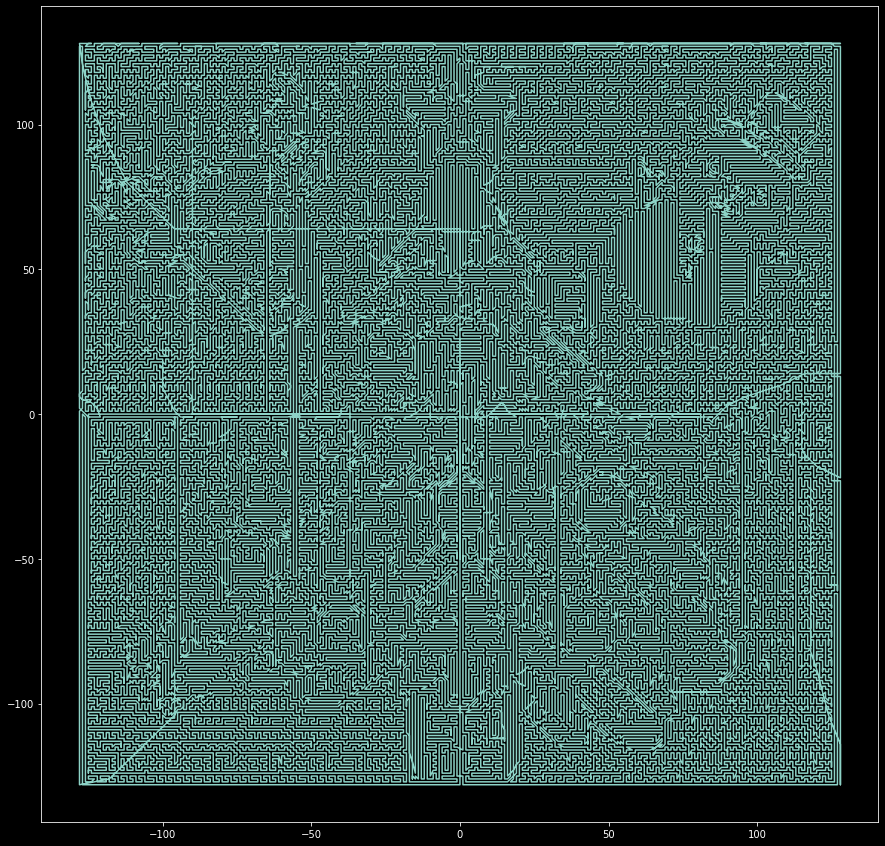

In [13]:
test_points = [get_position(i) for i in result]
draw_path(test_points, 'greed-approach')

In [14]:
submission = pd.Series(
    [config_to_string(config) for config in result],
    name="configuration",
)

submission.to_csv('submission.csv', index=False)
submission.head()

0     64 0;-32 0;-16 0;-8 0;-4 0;-2 0;-1 0;-1 0
1    64 -1;-32 0;-16 0;-8 0;-4 0;-2 0;-1 0;-1 0
2    64 -2;-32 0;-16 0;-8 0;-4 0;-2 0;-1 0;-1 0
3    64 -3;-32 0;-16 0;-8 0;-4 0;-2 0;-1 0;-1 0
4    64 -4;-32 0;-16 0;-8 0;-4 0;-2 0;-1 0;-1 0
Name: configuration, dtype: object